In [1]:
from MDAnalysis import Universe
from RCBS.md_analyser import selections
from RCBS.md_analyser import measurements
from RCBS.md_analyser import frame_extractor

import matplotlib.pyplot as plt

/Users/mikicanyelles/miniconda3/envs/py_env/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/mikicanyelles/miniconda3/envs/py_env/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Description of the example file

Example script for analysing a small trajectory using all the functions available in the Measurements class from md_analyser. Frame_extractor submodule is also exemplified in the last sections of the script.

# TOC

1. [Load parameters and trajectory](#load)
2. [Select the atoms to be used for the analysis](#select)
3. [Analysis of the trajectory](#trajanalysis)
4. [Plot the measurements with Matplotlib](#plot)
5. [Apply criteria for statistical analysis](#applycriteria)

# Load parameters and trajectory <a class="anchor" id="load"></a>

In this section the trajectory along with the parameters will be loaded as a MDAnalysis universe

In [2]:
parameters = 'parameters.prmtop' # AMBER parameters file
trajectory = 'trajectory.nc'     # AMBER NetCDF coordinates (10 frames)

u = Universe(parameters, trajectory)

# Select the atoms to be used for the analysis <a class="anchor" id="select"></a>

In [3]:
help(selections.selection)

Help on function selection in module RCBS.md_analyser.selections:

selection(u, sel_input, sel_type=None)
    This function takes an input number or name and type of selection (atom or residue or none)
    and transforms it into an MDAnalysis selection. The input can also be a list of numbers or name
    and it can combine both types of input by using a list of selection types (of the same lenght).
    
    sel_type: at_num, at_name, res, none
        at_num   -> atom number
        at_name  -> atom name
        res_num  -> residue number
        res_name -> residue name
        none     -> pipes the selection command directly



In [4]:
C10 = selections.selection(u, 'C10', sel_type='at_name')
C11 = selections.selection(u, 'C11', sel_type='at_name')
C12 = selections.selection(u, 'C12', sel_type='at_name')
C13 = selections.selection(u, 'C13', sel_type='at_name')
C14 = selections.selection(u, 'C14', sel_type='at_name')

H12 = selections.selection(u, ['H12A', 'H12B'], sel_type='at_name')
cof = selections.selection(u, 10597, sel_type='at_num')

COO = selections.selection(u, [10599, 10600, 10601], sel_type='at_num')

# Analysis of the trajectory <a class="anchor" id="trajanalysis"></a>

## Create the Measurements object

In [5]:
help(measurements.Measurements)

Help on class Measurements in module RCBS.md_analyser.measurements:

class Measurements(builtins.object)
 |  Measurements(u)
 |  
 |  DESCRIPTION:
 |      Class containing all the possible analysis of a trajectory that RCBS is able to carry out. It creates a dictionary of results (self.results) containing all the results of the configurated measurements (by add_* functions) and calculated using run_measure function, and creates a dictionary of boolean values (self.boolean) containing the result of applying a certain criterium to a certain measurement.
 |  
 |  FUNCTIONS:
 |      - add_distance: measure the distance between two atoms or two groups of atoms (and return the shorter one)
 |      - add_dihedral: measure the dihedral angle between four atoms
 |      - add_angle:    measure the angle between three atoms
 |      - add_contacts: measure the number of contacts at a given distance from a given selection of one or more atoms
 |      - run_measure:  run the all the measurements pre

In [6]:
m = measurements.Measurements(u)

## Add the measurements to compute

In [7]:
m.add_distance('dist_H12', cof, H12)
m.add_angle('angle_C11C12C13', C11, C12, C13)
m.add_dihedral('dihe_C10C11C13C14', C10, C11, C13, C14, domain=180)
m.add_contacts('contacts_COO', COO, sel_env=5, interactions='all', include_WAT=True)

## Run the measurements

In [8]:
m.run_measure() #Default arguments: save_output=False, input_config=False

# Plot the measurements with Matplotlib <a class="anchor" id="plot"></a>

## Distance measurement

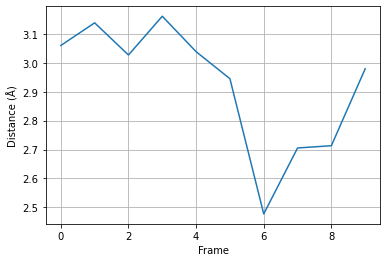

In [9]:
plt.plot(range(len(m.universe.trajectory)), m.results['dist_H12'])

plt.xlabel('Frame')
plt.ylabel('Distance (Å)')

plt.grid()
plt.show()

## Angle measurement

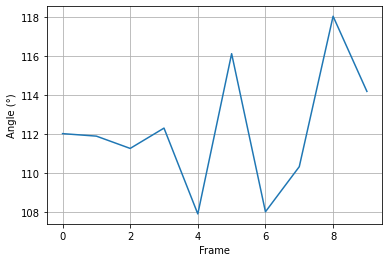

In [10]:
plt.plot(range(len(m.universe.trajectory)), m.results['angle_C11C12C13'])

plt.xlabel('Frame')
plt.ylabel('Angle (°)')

plt.grid()
plt.show()

## Dihedral measurement

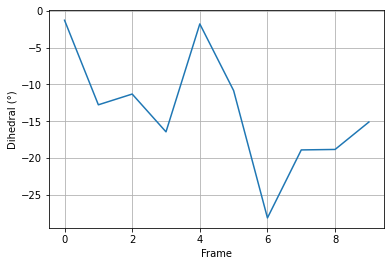

In [11]:
plt.plot(range(len(m.universe.trajectory)), m.results['dihe_C10C11C13C14'])

plt.xlabel('Frame')
plt.ylabel('Dihedral (°)')

plt.grid()
plt.show()

## Contacts measurement

In [12]:
# Convert the list of dictonaries of contacts (ID: residue_type) per frame to 
# a list of the number of contacts per frame

m.results['contacts_COO_len'] = []

for c in m.results['contacts_COO']:
    m.results['contacts_COO_len'].append(len(c))

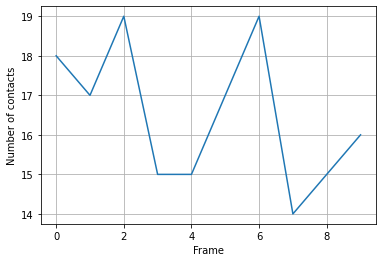

In [13]:
plt.plot(range(len(m.universe.trajectory)), m.results['contacts_COO_len'])

plt.xlabel('Frame')
plt.ylabel('Number of contacts')

plt.grid()
plt.show()

# Apply criteria for statistical analysis <a class="anchor" id="applycriteria"></a>

Two criteria will be applied: 

- Distance H12-cof (dist_H12) under 2.75 Å
- Dihedral angle C10-C11-C13-C14 (dihedral_C10C11C13C14) 5° around -15°

In [14]:
dist_criterium = {
                'measure_name' : 'dist_H12',
                'measure_type' : 'dist',
                'mode' : 'lim',
                'ref_val1' : 2.75,
}

dihe_criterium = {
                'measure_name': 'dihe_C10C11C13C14',
                'measure_type': 'dihe',
                'mode': 'tol',
                'ref_val1': -15,
                'ref_val2': 5
}

In [15]:
m.run_boolean(dist_criterium, dihe_criterium) # default arguments: combine=True, save_output=False

In [16]:
print('% of frames that satisfy the criterium applied to dist_H12:', str(round((m.boolean['dist_H12'].count(True)*100/len(m.universe.trajectory)))))
print('% of frames that satisfy the criterium applied to dihe_C10C11C13C14:', str(round((m.boolean['dihe_C10C11C13C14'].count(True)*100/len(m.universe.trajectory)))))

print('% of frames that satisfy all criteria:', str(round((m.boolean['combination'].count(True)*100/len(m.universe.trajectory)))))

% of frames that satisfy the criterium applied to dist_H12: 30
% of frames that satisfy the criterium applied to dihe_C10C11C13C14: 70
% of frames that satisfy all criteria: 20


# Extract frames that satisfy the criteria

In [17]:
help(frame_extractor.frame_selector)

Help on function frame_selector in module RCBS.md_analyser.frame_extractor:

frame_selector(frames_boolean, bins=10, frames_per_bin=1)
    DESCRIPTION:
        Function for randomly select frames from a boolean list (being the index the number of the frame).
    
    INPUT:
        - frames_boolean: list of boolean variables that indicate if the criteria is satisfied or not. The index of the list is the number of the frame.
        - bins:           number of partitions of the trajectory to properly distibute the selection
        - frames_per_bin: number of frames to select per bin
    
    OUTPUT:
        - list of randomly selected frames



In [18]:
# since the trajectory has only 10 frames and only 2 satisfy the criteria, the example will extract only one frame

selected_frames = frame_extractor.frame_selector(m.boolean['combination'], bins=1, frames_per_bin=1)

In [19]:
help(frame_extractor.trajectory_frame_extractor)

Help on function trajectory_frame_extractor in module RCBS.md_analyser.frame_extractor:

trajectory_frame_extractor(u, frame, name='', folder='', outformat='.pdb', solvent=True)
    DESCRIPTION:
        Function for saving a frame from a trajectory loaded as a MDAnalysis Universe
    
    INPUTS:
        u       --> MDAnalysis Universe
                --> It has to be a trajectory.
        frame   --> it can be a single frame (input as number or string of number) or a list of frames.
        name    --> name for the output file. If more than one frame is input, outputs will be secuencially named
        folder  --> folder name where pdbs have to be saved.
                --> if the folder does not exist, it will be created.
                --> by default, no folder is used
        format  --> format for the output file
                --> by default, output will be saved as pdb. All formats accepted by the write module of MDAnalysis are accepted.



In [20]:
frame_extractor.trajectory_frame_extractor(m.universe, selected_frames, folder='') 
# Default arguments: name='' (name of the frame), folder=''(current directory), outformat='.pdb', solvent=True

/Users/mikicanyelles/miniconda3/envs/py_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/mikicanyelles/miniconda3/envs/py_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/mikicanyelles/miniconda3/envs/py_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/Users/mikicanyelles/miniconda3/envs/py_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/Users/mikicanyelles/mi